# Multi-armed Bandit Recommender System

## Env

In [ ]:
import pandas as pd
import numpy as np
import random
import matplotlib.pyplot as plt
import Recommenders
import Bandits
import seaborn as sns

## Dataset

In [12]:
events = pd.read_csv(r'C:\Users\fldam\OneDrive\MBA\TCC\Code\Dataset\events.csv')
categories = pd.read_csv(r'C:\Users\fldam\OneDrive\MBA\TCC\Code\Dataset\category_tree.csv')
item_properties_part1 = pd.read_csv(r'C:\Users\fldam\OneDrive\MBA\TCC\Code\Dataset\item_properties_part1.csv')
item_properties_part2 = pd.read_csv(r'C:\Users\fldam\OneDrive\MBA\TCC\Code\Dataset\item_properties_part2.csv')

In [13]:
# Concatenate item_properties_part1 and item_properties_part2
properties = pd.concat([item_properties_part1, item_properties_part2], ignore_index=True)

## Data Exploring, Cleaning and Feature Engineering

### Events

#### itemid

In [14]:
# Filter only events with itemid in properties
events = events[events['itemid'].isin(properties['itemid'])]

### Recommended items and user picking

#### Items

In [15]:
# Store the most representative purchased items
rec_items = events[events['event'] == 'transaction']['itemid']\
    .value_counts(normalize=True)\
        .sort_values(ascending=False)\
            .cumsum()\
                .loc[lambda x: x <= 0.8].index.tolist()

There might be some items that were purchased but not viewed or added to cart. These could be taken out of the recommended items list as we want optimize the user interaction in all ways with the purchased items

In [16]:
# Check if all items that were purchased were also viewed or added to cart
purchased_notviewed_notadded = events[((events['event'] == 'transaction') & 
       (events['itemid']
        .isin(events[events['event'] == 'view']['itemid'])==False)) | 
       ((events['event'] == 'transaction') & 
       (events['itemid']
        .isin(events[events['event'] == 'addtocart']['itemid'])==False))]['itemid'].unique()


In [17]:
# Remove the items that were purchased but not viewed or added to cart from the rec_items list
rec_items = [itm for itm in rec_items if itm not in purchased_notviewed_notadded]

### Properties

In [13]:
properties = properties[properties['itemid'].isin(events['itemid'].unique())]

In [14]:
# Convert 'timestamp' to datetime format
properties['timestamp'] = pd.to_datetime(properties['timestamp'], unit='ms', origin='unix')

#### Pre-processing properties

In [19]:
# Timestamp mínimo por itemid na tabela de propriedades
min_ts_props = properties_grouped.groupby('itemid')['timestamp'].min()

# Merge para trazer a data mínima das propriedades para os eventos
events_filtered = events.merge(
    min_ts_props.rename('min_prop_ts'), 
    on='itemid', 
    how='left'
)

# Filtra eventos ocorridos após a primeira propriedade do item
events_filtered = events_filtered[events_filtered['timestamp'] >= events_filtered['min_prop_ts']]
events_filtered = events_filtered.drop(columns='min_prop_ts')

NameError: name 'properties_grouped' is not defined

In [15]:
# Ordena para merge_asof
events_filtered = events_filtered.sort_values(['timestamp', 'itemid'])
properties_grouped = properties_grouped.sort_values(['timestamp', 'itemid'])

# Junta o contexto mais recente antes de cada evento
df_merged = pd.merge_asof(
    events_filtered,
    properties_grouped[['itemid', 'timestamp', 'context']],
    on='timestamp',
    by='itemid',
    direction='backward'
)

NameError: name 'events_filtered' is not defined

### Categories

In [4]:
rootcat = categories[categories['parentid'].isnull()]
firstgencat = categories[categories['parentid'].isin(rootcat['categoryid'])]
secondgencat = categories[categories['parentid'].isin(firstgencat['categoryid'])]
thirdgencat = categories[categories['parentid'].isin(secondgencat['categoryid'])]
fourthgencat = categories[categories['parentid'].isin(thirdgencat['categoryid'])]
fifthgencat = categories[categories['parentid'].isin(fourthgencat['categoryid'])]

In [5]:
root = rootcat.rename(columns={'categoryid': 'root'}).drop(columns='parentid')
layer_1 = firstgencat.rename(columns={'categoryid': 'layer_1', 'parentid': 'root'})
layer_2 = secondgencat.rename(columns={'categoryid': 'layer_2', 'parentid': 'layer_1'})
layer_3 = thirdgencat.rename(columns={'categoryid': 'layer_3', 'parentid': 'layer_2'})
layer_4 = fourthgencat.rename(columns={'categoryid': 'layer_4', 'parentid': 'layer_3'})
layer_5 = fifthgencat.rename(columns={'categoryid': 'layer_5', 'parentid': 'layer_4'})

In [6]:
tree_l5 = layer_5.merge(layer_4, on='layer_4').merge(layer_3, on='layer_3').merge(layer_2, on='layer_2').merge(layer_1, on='layer_1').merge(root, on='root')
tree_l4 = layer_4.merge(layer_3, on='layer_3').merge(layer_2, on='layer_2').merge(layer_1, on='layer_1').merge(root, on='root')
tree_l3 = layer_3.merge(layer_2, on='layer_2').merge(layer_1, on='layer_1').merge(root, on='root')
tree_l2 = layer_2.merge(layer_1, on='layer_1').merge(root, on='root')
tree_l1 = layer_1.merge(root, on='root')
cat_tree = pd.concat([tree_l1, tree_l2, tree_l3, tree_l4, tree_l5], ignore_index=True)

In [7]:
neworder = ['root','layer_1','layer_2','layer_3','layer_4','layer_5']
cat_tree = cat_tree.reindex(neworder, axis=1).sort_values(by=neworder)
cat_tree

,root,layer_1,layer_2,layer_3,layer_4,layer_5
1151,140.0,61.0,323.0,1558.0,NaN,NaN
760,140.0,61.0,323.0,NaN,NaN,NaN
1153,140.0,61.0,897.0,120.0,NaN,NaN
1007,140.0,61.0,897.0,1098.0,NaN,NaN
1528,140.0,61.0,897.0,1317.0,NaN,NaN
...,...,...,...,...,...,...
732,1698.0,1678.0,305.0,NaN,NaN,NaN
730,1698.0,1678.0,455.0,NaN,NaN,NaN
779,1698.0,1678.0,1346.0,NaN,NaN,NaN
731,1698.0,1678.0,1554.0,NaN,NaN,NaN


## MAB Implementation

In [18]:
#
prop_test = properties[properties['property']=='categoryid']
prop_test['timestamp'] = pd.to_datetime(prop_test['timestamp'], unit='ms', origin='unix')
events['timestamp'] = pd.to_datetime(events['timestamp'], unit='ms', origin='unix')

C:\Users\fldam\AppData\Local\Temp\ipykernel_12260\4038205902.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  prop_test['timestamp'] = pd.to_datetime(prop_test['timestamp'], unit='ms', origin='unix')


In [34]:
# Verifying the event distribution for the most frequent visitor
events[events['visitorid'] == events['visitorid'].value_counts().index[1]]['event'].value_counts()

event
view           2738
addtocart       405
transaction     276
Name: count, dtype: int64

In [35]:
maxvisitor_events = events[events['visitorid'] == events['visitorid'].value_counts().index[1]]
maxvisitor_events

,timestamp,visitorid,event,itemid,transactionid
261793,2015-06-16 00:13:01.237,530559,view,371551,NaN
263557,2015-06-15 20:02:25.898,530559,view,21988,NaN
263568,2015-06-15 19:36:51.103,530559,transaction,362858,14083.0
263581,2015-06-15 19:36:51.103,530559,transaction,439963,14083.0
263739,2015-06-15 19:05:08.755,530559,view,360487,NaN
...,...,...,...,...,...
2735359,2015-07-30 20:45:04.651,530559,view,323030,NaN
2735417,2015-07-30 20:44:37.034,530559,view,234613,NaN
2735789,2015-07-30 20:03:36.825,530559,view,450930,NaN
2735877,2015-07-30 20:06:10.165,530559,addtocart,450930,NaN


In [36]:
merged = maxvisitor_events.merge(prop_test, on='itemid', how='left')
validos = merged[merged['timestamp_y'] <= merged['timestamp_x']].copy()

validos['time_diff'] = (validos['timestamp_x'] - validos['timestamp_y'])

resultado = validos.loc[validos.groupby(['itemid', 'timestamp_x'])['time_diff'].idxmin()].reset_index(drop=True)
resultado.drop(columns=['timestamp_y', 'time_diff', 'property'], inplace=True)
resultado

,timestamp_x,visitorid,event,itemid,transactionid,value
0,2015-06-28 02:06:38.029,530559,view,66,NaN,1080
1,2015-06-28 02:07:01.514,530559,view,66,NaN,1080
2,2015-08-22 16:19:32.715,530559,view,546,NaN,1349
3,2015-08-22 20:36:35.754,530559,view,546,NaN,1349
4,2015-08-24 15:33:34.130,530559,view,546,NaN,1349
...,...,...,...,...,...,...
3269,2015-07-20 01:51:34.719,530559,view,466488,NaN,352
3270,2015-09-15 16:46:25.863,530559,view,466603,NaN,126
3271,2015-09-15 16:46:33.419,530559,addtocart,466603,NaN,126
3272,2015-09-15 23:25:12.901,530559,view,466603,NaN,126


In [37]:
# Transform column 'value' into a list of integers
resultado['value'] = resultado['value'].apply(lambda x: int(x))

In [38]:
cat_tree['_cat_id'] = cat_tree.index

categorias_long = cat_tree.melt(
    id_vars=['_cat_id'], 
    value_vars=['root', 'layer_1', 'layer_2', 'layer_3', 'layer_4', 'layer_5'],
    var_name='layer',
    value_name='value'
)
categorias_long = categorias_long.dropna(subset=['value']).drop_duplicates(subset=['value'])
mapa_categoria = categorias_long.set_index('value')['_cat_id'].to_dict()
resultado['_cat_id'] = resultado['value'].map(mapa_categoria)

resultado_final = resultado.merge(cat_tree, on='_cat_id', how='left').drop(columns=['_cat_id'])
resultado_final

,timestamp_x,visitorid,event,itemid,transactionid,value,root,layer_1,layer_2,layer_3,layer_4,layer_5
0,2015-06-28 02:06:38.029,530559,view,66,NaN,1080,653.0,312.0,1281.0,1080.0,NaN,NaN
1,2015-06-28 02:07:01.514,530559,view,66,NaN,1080,653.0,312.0,1281.0,1080.0,NaN,NaN
2,2015-08-22 16:19:32.715,530559,view,546,NaN,1349,140.0,540.0,121.0,1349.0,NaN,NaN
3,2015-08-22 20:36:35.754,530559,view,546,NaN,1349,140.0,540.0,121.0,1349.0,NaN,NaN
4,2015-08-24 15:33:34.130,530559,view,546,NaN,1349,140.0,540.0,121.0,1349.0,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...
3269,2015-07-20 01:51:34.719,530559,view,466488,NaN,352,859.0,352.0,NaN,NaN,NaN,NaN
3270,2015-09-15 16:46:25.863,530559,view,466603,NaN,126,1224.0,871.0,126.0,NaN,NaN,NaN
3271,2015-09-15 16:46:33.419,530559,addtocart,466603,NaN,126,1224.0,871.0,126.0,NaN,NaN,NaN
3272,2015-09-15 23:25:12.901,530559,view,466603,NaN,126,1224.0,871.0,126.0,NaN,NaN,NaN


In [39]:
resultado_final['root'] = np.nan_to_num(resultado_final['root'])
resultado_final['layer_1'] = np.nan_to_num(resultado_final['layer_1'])
resultado_final['layer_2'] = np.nan_to_num(resultado_final['layer_2'])
resultado_final['layer_3'] = np.nan_to_num(resultado_final['layer_3'])
resultado_final['layer_4'] = np.nan_to_num(resultado_final['layer_4'])
resultado_final['layer_5'] = np.nan_to_num(resultado_final['layer_5'])

In [40]:
# Transform 'root', 'layer_1', 'layer_2', 'layer_3', 'layer_4', 'layer_5' columns from resultado_final into a single vector
resultado_final['context'] = resultado_final.apply(lambda row: \
                                                             [row['root'],row['layer_1'],row['layer_2'], \
                                                              row['layer_3'], row['layer_4'], row['layer_5']], axis=1)

In [41]:
context_events = resultado_final[['timestamp_x', 'itemid','context', 'event']].rename(columns={'timestamp_x': 'timestamp'})

In [42]:
context_events['context'] = context_events['context'].apply(lambda x: np.array(x))
context_events

,timestamp,itemid,context,event
0,2015-06-28 02:06:38.029,66,"[653.0, 312.0, 1281.0, 1080.0, 0.0, 0.0]",view
1,2015-06-28 02:07:01.514,66,"[653.0, 312.0, 1281.0, 1080.0, 0.0, 0.0]",view
2,2015-08-22 16:19:32.715,546,"[140.0, 540.0, 121.0, 1349.0, 0.0, 0.0]",view
3,2015-08-22 20:36:35.754,546,"[140.0, 540.0, 121.0, 1349.0, 0.0, 0.0]",view
4,2015-08-24 15:33:34.130,546,"[140.0, 540.0, 121.0, 1349.0, 0.0, 0.0]",view
...,...,...,...,...
3269,2015-07-20 01:51:34.719,466488,"[859.0, 352.0, 0.0, 0.0, 0.0, 0.0]",view
3270,2015-09-15 16:46:25.863,466603,"[1224.0, 871.0, 126.0, 0.0, 0.0, 0.0]",view
3271,2015-09-15 16:46:33.419,466603,"[1224.0, 871.0, 126.0, 0.0, 0.0, 0.0]",addtocart
3272,2015-09-15 23:25:12.901,466603,"[1224.0, 871.0, 126.0, 0.0, 0.0, 0.0]",view


In [43]:
# Transform every row in cat_tree into a vector
def vectorize_categories(cat_tree):
    vectors = []
    for _, row in cat_tree.iterrows():
        vector = []
        for col in ['root', 'layer_1', 'layer_2', 'layer_3', 'layer_4', 'layer_5']:
            vector.append(row[col])
        vectors.append(vector)
    return np.array(vectors)

In [44]:
cat_vectors = vectorize_categories(cat_tree)
cat_vectors = np.nan_to_num(cat_vectors)
cat_vectors

array([[ 140.,   61.,  323., 1558.,    0.,    0.],
       [ 140.,   61.,  323.,    0.,    0.,    0.],
       [ 140.,   61.,  897.,  120.,    0.,    0.],
       ...,
       [1698., 1678., 1346.,    0.,    0.,    0.],
       [1698., 1678., 1554.,    0.,    0.,    0.],
       [1698., 1678.,    0.,    0.,    0.,    0.]], shape=(1644, 6))

In [45]:
rec_items_test = prop_test[prop_test['itemid'].isin(rec_items)]
rec_items_test

,timestamp,itemid,property,value
1441,2015-05-10 03:00:00,38175,categoryid,196
5312,2015-05-10 03:00:00,285055,categoryid,1167
5914,2015-06-28 03:00:00,172842,categoryid,366
7554,2015-06-28 03:00:00,282528,categoryid,366
9009,2015-07-19 03:00:00,190070,categoryid,1613
...,...,...,...,...
20270731,2015-09-06 03:00:00,321668,categoryid,438
20271676,2015-08-16 03:00:00,151125,categoryid,224
20272305,2015-05-31 03:00:00,150857,categoryid,1135
20272703,2015-05-24 03:00:00,190594,categoryid,705


In [46]:
# Transform column 'value' into a list of integers
prop_test['value'] = prop_test['value'].apply(lambda x: int(x))

# Map 'value' to '_cat_id' using mapa_categoria
prop_test['_cat_id'] = prop_test['value'].map(mapa_categoria)

# Map 'value' to 'category' using cat_tree
prop_test = prop_test.merge(cat_tree, on='_cat_id', how='left').drop(columns=['_cat_id'])

In [47]:
cat_tree['_cat_id'] = cat_tree.index

categorias_long = cat_tree.melt(
    id_vars=['_cat_id'], 
    value_vars=['root', 'layer_1', 'layer_2', 'layer_3', 'layer_4', 'layer_5'],
    var_name='layer',
    value_name='value'
)
categorias_long = categorias_long.dropna(subset=['value']).drop_duplicates(subset=['value'])
mapa_categoria = categorias_long.set_index('value')['_cat_id'].to_dict()

rec_items_test['value'] = rec_items_test['value'].apply(lambda x: int(x))

rec_items_test['_cat_id'] = rec_items_test['value'].map(mapa_categoria)

rec_items_test = rec_items_test.merge(cat_tree, on='_cat_id', how='left').drop(columns=['_cat_id'])
rec_items_test

,timestamp,itemid,property,value,root,layer_1,layer_2,layer_3,layer_4,layer_5
0,2015-05-10 03:00:00,38175,categoryid,196,140.0,409.0,1667.0,196.0,NaN,NaN
1,2015-05-10 03:00:00,285055,categoryid,1167,250.0,1167.0,NaN,NaN,NaN,NaN
2,2015-06-28 03:00:00,172842,categoryid,366,1482.0,143.0,366.0,NaN,NaN,NaN
3,2015-06-28 03:00:00,282528,categoryid,366,1482.0,143.0,366.0,NaN,NaN,NaN
4,2015-07-19 03:00:00,190070,categoryid,1613,250.0,1613.0,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...
14064,2015-09-06 03:00:00,321668,categoryid,438,653.0,312.0,438.0,NaN,NaN,NaN
14065,2015-08-16 03:00:00,151125,categoryid,224,140.0,920.0,1487.0,224.0,NaN,NaN
14066,2015-05-31 03:00:00,150857,categoryid,1135,140.0,1519.0,1329.0,1135.0,NaN,NaN
14067,2015-05-24 03:00:00,190594,categoryid,705,140.0,920.0,1487.0,705.0,NaN,NaN


In [48]:
prop_test['root'] = np.nan_to_num(prop_test['root'])
prop_test['layer_1'] = np.nan_to_num(prop_test['layer_1'])
prop_test['layer_2'] = np.nan_to_num(prop_test['layer_2'])
prop_test['layer_3'] = np.nan_to_num(prop_test['layer_3'])
prop_test['layer_4'] = np.nan_to_num(prop_test['layer_4'])
prop_test['layer_5'] = np.nan_to_num(prop_test['layer_5'])

prop_test['context'] = prop_test.apply(lambda row: \
                                                             [row['root'],row['layer_1'],row['layer_2'], \
                                                              row['layer_3'], row['layer_4'], row['layer_5']], axis=1)

prop_test = prop_test[['timestamp', 'itemid','context']]

In [49]:
rec_items_test['root'] = np.nan_to_num(rec_items_test['root'])
rec_items_test['layer_1'] = np.nan_to_num(rec_items_test['layer_1'])
rec_items_test['layer_2'] = np.nan_to_num(rec_items_test['layer_2'])
rec_items_test['layer_3'] = np.nan_to_num(rec_items_test['layer_3'])
rec_items_test['layer_4'] = np.nan_to_num(rec_items_test['layer_4'])
rec_items_test['layer_5'] = np.nan_to_num(rec_items_test['layer_5'])

rec_items_test['context'] = rec_items_test.apply(lambda row: \
                                                             [row['root'],row['layer_1'],row['layer_2'], \
                                                              row['layer_3'], row['layer_4'], row['layer_5']], axis=1)

rec_items_test = rec_items_test[['timestamp', 'itemid','context']]

In [50]:
context_events.sort_values(by='timestamp', inplace=True)

In [38]:
rec_items_test = rec_items_test[rec_items_test['timestamp'] \
                                <= context_events['timestamp'].max()].sort_values(by='timestamp')

In [31]:
# Instancia o modelo
n_features = len(context_events.iloc[0]['context'])
modelo_usuario = Bandits.EpsilonGreedy(epsilon=0.3, n_features=n_features)

# Simula
df_resultado_usuario = Recommenders.simular_recomendacao_top5_epsilon_greedy(context_events, rec_items_test, modelo_usuario)

In [32]:
context_events['event'].value_counts()

event
view           2610
addtocart       396
transaction     268
Name: count, dtype: int64

In [33]:
df_resultado_usuario['reward'].value_counts().sort_index()

reward
0.0    2619
0.1     209
0.5     267
1.0     149
Name: count, dtype: int64

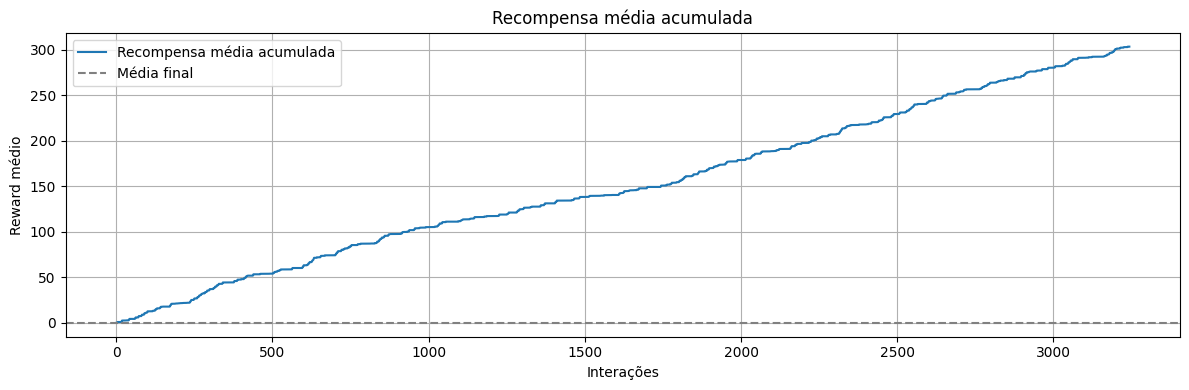

In [ ]:
plt.figure(figsize=(12, 4))
plt.plot(df_resultado_usuario['reward'].cumsum(), label='Recompensa acumulada')
plt.axhline(df_resultado_usuario['reward'].mean(), color='gray', linestyle='--', label='Média final')
plt.title(f'Recompensa média acumulada')
plt.xlabel('Interações')
plt.ylabel('Reward médio')
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

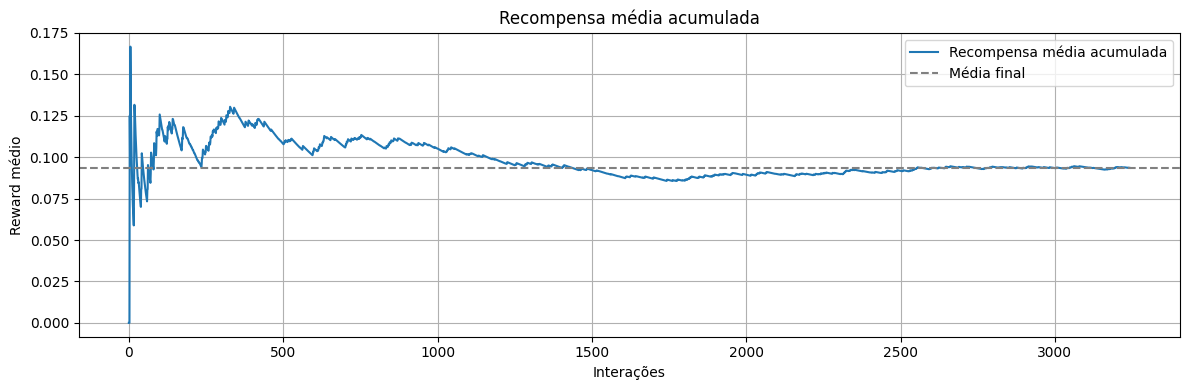

In [35]:
plt.figure(figsize=(12, 4))
plt.plot(df_resultado_usuario['reward'].expanding().mean(), label='Recompensa média acumulada')
plt.axhline(df_resultado_usuario['reward'].mean(), color='gray', linestyle='--', label='Média final')
plt.title(f'Recompensa média acumulada')
plt.xlabel('Interações')
plt.ylabel('Reward médio')
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

In [36]:
weights = modelo_usuario.weights
weights_df = pd.DataFrame.from_dict(weights, orient='index')
weights_df

,0,1,2,3,4,5
393768,-3.244856e+13,-3.415211e+13,-3.257024e+13,-1.385148e+13,0.000000e+00,0.0
369158,-3.280163e+13,-3.452371e+13,-3.292463e+13,-1.066053e+13,-9.635478e+12,0.0
362858,-5.909535e+07,-4.358860e+06,-1.654824e+07,0.000000e+00,0.000000e+00,0.0
439963,-1.742607e+91,-3.332793e+90,-1.212545e+91,-9.020154e+90,0.000000e+00,0.0
371551,-4.861012e+15,-1.420110e+16,-3.802006e+16,-3.329794e+16,-2.413145e+16,0.0
...,...,...,...,...,...,...
410056,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.0
375876,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.0
461190,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.0
451703,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.0


In [ ]:
# Define a function to pick n top users based on the number of events and process the dataset for each user
def process_top_n_users(n):
    # Loop through the top n users
    for i in range(n):
        # Get the events for the current user
        maxvisitor_events = events[events['visitorid'] == events['visitorid'].value_counts().index[i]]
        # Merge with property test
        merged = maxvisitor_events.merge(prop_test, on='itemid', how='left')
        # Filter valid properties
        validos = merged[merged['timestamp_y'] <= merged['timestamp_x']].copy()
        # Calculate time difference
        validos['time_diff'] = (validos['timestamp_x'] - validos['timestamp_y'])
        # Get the closest property for each event
        resultado = validos.loc[validos.groupby(['itemid', 'timestamp_x'])['time_diff'].idxmin()].reset_index(drop=True)
        # Drop unnecessary columns
        resultado.drop(columns=['timestamp_y', 'time_diff', 'property'], inplace=True)
        # Transform column 'value' into a list of integers
        resultado['value'] = resultado['value'].apply(lambda x: int(x))
        # Map 'value' to '_cat_id' using mapa_categoria
        resultado['_cat_id'] = resultado['value'].map(mapa_categoria)
        # Merge with cat_tree to get category layers
        resultado_final = resultado.merge(cat_tree, on='_cat_id', how='left').drop(columns=['_cat_id'])
        # Handle NaN values in category layers
        resultado_final['root'] = np.nan_to_num(resultado_final['root'])
        resultado_final['layer_1'] = np.nan_to_num(resultado_final['layer_1'])
        resultado_final['layer_2'] = np.nan_to_num(resultado_final['layer_2'])
        resultado_final['layer_3'] = np.nan_to_num(resultado_final['layer_3'])
        resultado_final['layer_4'] = np.nan_to_num(resultado_final['layer_4'])
        resultado_final['layer_5'] = np.nan_to_num(resultado_final['layer_5'])
        # Transform 'root', 'layer_1', 'layer_2', 'layer_3', 'layer_4', 'layer_5' columns from resultado_final into a single vector
        resultado_final['context'] = resultado_final.apply(lambda row: \
                                                                    [row['root'],row['layer_1'],row['layer_2'], \
                                                                    row['layer_3'], row['layer_4'], row['layer_5']], axis=1)
        # Prepare context_events for the user
        context_events = resultado_final[['timestamp_x', 'itemid','context', 'event']].rename(columns={'timestamp_x': 'timestamp'})
        # Transform 'context' column to numpy array
        context_events['context'] = context_events['context'].apply(lambda x: np.array(x))
        # Filter rec_items_test to include only items within the timestamp range of context_events
        rec_items_test = rec_items_test[rec_items_test['timestamp'] \
                                        <= context_events['timestamp'].max()].sort_values(by='timestamp')
        # Instantiates the model
        n_features = len(context_events.iloc[0]['context'])
        modelo_usuario = Bandits.EpsilonGreedy(epsilon=0.3, n_features=n_features)

        # For each user, simulate the recommendation and store the result separately with the user index in the filename
        df_resultado_usuario = pd.DataFrame()
        # Create a unique variable name for each user result
        globals()[f'df_resultado_usuario_{i}'] = Recommenders.simular_recomendacao_top5_epsilon_greedy(context_events, rec_items_test, modelo_usuario)

In [39]:
def process_top_n_users(n, events, prop_test, rec_items_test, mapa_categoria, cat_tree):
    """
    Process the top-n users by event count and simulate recommendations for each user.

    Parameters
    ----------
    n : int -> Number of top users to process.
    events : pd.DataFrame -> Event dataset containing 'visitorid', 'itemid', 'timestamp', 'event'.
    prop_test : pd.DataFrame -> Property dataset containing 'itemid', 'timestamp', 'value'.
    rec_items_test : pd.DataFrame -> Recommendation items dataset containing 'itemid', 'timestamp'.
    mapa_categoria : dict -> Mapping of property values to category IDs.
    cat_tree : pd.DataFrame -> Category tree containing category layers for each `_cat_id`.

    Returns
    -------
    dict
        Dictionary mapping user_rank (0..n-1) -> result DataFrame.
    """
    results = {}

    # Select top-n users by event count
    top_users = events['visitorid'].value_counts().index[:n]

    for i, user_id in enumerate(top_users):
        # Get events for the current user
        user_events = events[events['visitorid'] == user_id]

        # Merge with property test
        merged = user_events.merge(prop_test, on='itemid', how='left')

        # Keep only valid properties
        validos = merged[merged['timestamp_y'] <= merged['timestamp_x']].copy()
        if validos.empty:
            continue

        # Calculate time difference
        validos['time_diff'] = validos['timestamp_x'] - validos['timestamp_y']

        # Get the closest property for each event
        resultado = validos.loc[
            validos.groupby(['itemid', 'timestamp_x'])['time_diff'].idxmin()
        ].reset_index(drop=True)

        # Drop unnecessary columns
        resultado.drop(columns=['timestamp_y', 'time_diff', 'property'], inplace=True, errors="ignore")

        # Convert 'value' safely to integer
        resultado['value'] = pd.to_numeric(resultado['value'], errors='coerce').fillna(0).astype(int)

        # Map 'value' to '_cat_id'
        resultado['_cat_id'] = resultado['value'].map(mapa_categoria)

        # Merge with cat_tree
        resultado_final = resultado.merge(cat_tree, on='_cat_id', how='left').drop(columns=['_cat_id'])

        # Fill NaNs with 0 and cast to int
        layer_cols = ['root','layer_1','layer_2','layer_3','layer_4','layer_5']
        resultado_final[layer_cols] = resultado_final[layer_cols].fillna(0).astype(int)

        # Build context vectors
        resultado_final['context'] = resultado_final[layer_cols].values.tolist()

        # Prepare context_events
        context_events = resultado_final[['timestamp_x', 'itemid', 'context', 'event']].rename(
            columns={'timestamp_x': 'timestamp'}
        )
        context_events['context'] = context_events['context'].apply(lambda x: np.array(x))

        # Filter rec_items_test for this user
        rec_items_test_user = rec_items_test[
            rec_items_test['timestamp'] <= context_events['timestamp'].max()
        ].sort_values(by='timestamp').copy()

        if context_events.empty or rec_items_test_user.empty:
            continue

        # Instantiate model
        n_features = len(context_events.iloc[0]['context'])
        modelo_usuario = Bandits.EpsilonGreedy(epsilon=0.3, n_features=n_features)

        # Run recommender
        result_df = Recommenders.simular_recomendacao_top5_epsilon_greedy(
            context_events, rec_items_test_user, modelo_usuario
        )

        # Store result for this user's rank index
        results[i] = result_df

    return results

In [59]:
# First, make sure to import the required classes at the top of your script
from Bandits import EpsilonGreedy  # Import your EpsilonGreedy class
from Recommenders import simular_recomendacao_top5_epsilon_greedy  # Import your recommender function
import numpy as np
import pandas as pd

def process_top_n_users(n, events, prop_test, rec_items_test, mapa_categoria, cat_tree):
    """
    Process the top-n users by event count and simulate recommendations for each user.
    """
    results = {}
    
    print(f"Processing top {n} users...")
    
    # Precompute top users
    top_users = events['visitorid'].value_counts().head(n).index.tolist()
    
    for i, user_id in enumerate(top_users):
        try:
            print(f"Processing user {i+1}/{n}: {user_id}")
            
            # Get user events
            user_mask = events['visitorid'] == user_id
            user_events = events.loc[user_mask].copy()
            
            if user_events.empty:
                print(f"  No events for user {user_id}")
                continue

            # Merge with property test to get context
            merged = pd.merge(
                user_events, 
                prop_test[['itemid', 'timestamp', 'context']], 
                on='itemid', 
                how='inner',
                suffixes=('_event', '_prop')
            )
            
            if merged.empty:
                print(f"  No matching properties for user {user_id}")
                continue

            # Filter for valid properties (property timestamp <= event timestamp)
            valid_mask = merged['timestamp_prop'] <= merged['timestamp_event']
            validos = merged.loc[valid_mask].copy()
            
            if validos.empty:
                print(f"  No valid properties for user {user_id}")
                continue

            # Find the most recent property for each event
            validos['time_diff'] = validos['timestamp_event'] - validos['timestamp_prop']
            min_time_diff = validos.groupby(['itemid', 'timestamp_event'])['time_diff'].transform('min')
            closest_mask = validos['time_diff'] == min_time_diff
            
            resultado = validos.loc[closest_mask].drop_duplicates(
                subset=['itemid', 'timestamp_event'], 
                keep='first'
            ).reset_index(drop=True)

            # Clean up columns
            cols_to_drop = ['timestamp_prop', 'time_diff', 'transactionid']
            cols_to_drop = [col for col in cols_to_drop if col in resultado.columns]
            resultado.drop(columns=cols_to_drop, inplace=True)

            # Convert context from list to numpy array (much more efficient)
            print(f"  Converting context from list to numpy arrays...")
            resultado['context'] = resultado['context'].apply(lambda x: np.array(x, dtype=np.float32))
            
            # Prepare context_events
            context_events = resultado[['timestamp_event', 'itemid', 'context', 'event']].rename(
                columns={'timestamp_event': 'timestamp'}
            )

            # Filter rec_items_test for this user's timeframe
            max_timestamp = context_events['timestamp'].max()
            rec_items_test_user = rec_items_test[
                rec_items_test['timestamp'] <= max_timestamp
            ].copy()

            if context_events.empty or rec_items_test_user.empty:
                print(f"  Empty context events or recommendation items for user {user_id}")
                continue

            # Convert rec_items_test context to numpy arrays
            if 'context' in rec_items_test_user.columns:
                rec_items_test_user['context'] = rec_items_test_user['context'].apply(
                    lambda x: np.array(x, dtype=np.float32) if isinstance(x, list) else x
                )
            else:
                # If rec_items_test doesn't have context, get latest from prop_test
                print(f"  rec_items_test missing context, merging with latest properties...")
                latest_props = prop_test.loc[prop_test.groupby('itemid')['timestamp'].idxmax()]
                rec_items_test_user = pd.merge(
                    rec_items_test_user,
                    latest_props[['itemid', 'context']],
                    on='itemid',
                    how='left'
                )
                rec_items_test_user['context'] = rec_items_test_user['context'].apply(
                    lambda x: np.array(x, dtype=np.float32) if isinstance(x, list) else np.array([0], dtype=np.float32)
                )

            # Instantiate model
            n_features = len(context_events.iloc[0]['context'])
            modelo_usuario = EpsilonGreedy(epsilon=0.3, n_features=n_features, learning_rate=0.1)

            print(f"  Running recommender with {len(context_events)} events and {len(rec_items_test_user)} candidate items")
            print(f"  Context dimension: {n_features}")
            
            # Run recommender
            result_df = simular_recomendacao_top5_epsilon_greedy(
                context_events, rec_items_test_user, modelo_usuario
            )

            results[i] = result_df
            print(f"  Completed user {user_id} with {len(result_df)} recommendations")

        except Exception as e:
            print(f"Error processing user {user_id}: {str(e)}")
            import traceback
            traceback.print_exc()
            continue

    return results

In [64]:
import numpy as np
import pandas as pd
from Bandits import EpsilonGreedy
from Recommenders import simular_recomendacao_top5_epsilon_greedy
from bisect import bisect_right
import time

def process_top_n_users_optimized(n, events, prop_test, rec_items_test, mapa_categoria, cat_tree):
    """
    Highly optimized version for large datasets, updated for new bandit/recommender.
    """
    results = {}
    
    print(f"Processing top {n} users...")
    
    # Precompute top users
    top_users = events['visitorid'].value_counts().nlargest(n).index.tolist()
    
    # Pre-sort and preprocess data for faster access
    events_sorted = events.sort_values('visitorid').set_index('visitorid', drop=False)
    prop_test_sorted = prop_test.sort_values('itemid').set_index('itemid', drop=False)
    rec_items_sorted = rec_items_test.sort_values('timestamp')
    
    # Precompute latest context for each item (for recommendation candidates)
    print("Precomputing latest item contexts...")
    latest_contexts = prop_test_sorted.loc[prop_test_sorted.groupby('itemid')['timestamp'].idxmax()]
    
    # Convert contexts to numpy arrays efficiently
    item_context_map = {}
    for item_id, row in latest_contexts.iterrows():
        context = row['context']
        if isinstance(context, (list, np.ndarray)):
            item_context_map[item_id] = np.array(context, dtype=np.float32)
        else:
            item_context_map[item_id] = np.array([0], dtype=np.float32)
    
    for i, user_id in enumerate(top_users):
        user_start_time = time.time()
        try:
            print(f"\nProcessing user {i+1}/{n}: {user_id}")
            
            # Fast user events retrieval using pre-sorted index
            user_events = events_sorted.loc[[user_id]].copy()
            if user_events.empty:
                continue
                
            print(f"  User has {len(user_events)} events")

            # Batch process: get all unique items for this user
            user_items = user_events['itemid'].unique()
            
            # Fast property lookup using pre-sorted index
            user_props = prop_test_sorted.loc[prop_test_sorted.index.intersection(user_items)].copy()
            if user_props.empty:
                continue

            # Vectorized timestamp filtering and context assignment
            print("  Processing events with optimized operations...")
            
            # Create event-property pairs efficiently using vectorized operations
            event_prop_pairs = []
            
            # Group events by item for efficient processing
            for item_id in user_items:
                item_events = user_events[user_events['itemid'] == item_id]
                item_props = user_props[user_props.index == item_id]
                
                if not item_props.empty:
                    # Get the latest property for this item
                    latest_prop = item_props.nlargest(1, 'timestamp').iloc[0]
                    latest_context = latest_prop['context']
                    
                    # Convert context to numpy array if needed
                    if isinstance(latest_context, (list, np.ndarray)):
                        context_array = np.array(latest_context, dtype=np.float32)
                    else:
                        context_array = np.array([0], dtype=np.float32)
                    
                    # Assign this context to all events for this item
                    for _, event_row in item_events.iterrows():
                        event_prop_pairs.append({
                            'timestamp': event_row['timestamp'],
                            'itemid': item_id,
                            'context': context_array,
                            'event': event_row['event']
                        })

            if not event_prop_pairs:
                continue
                
            # Create context_events DataFrame efficiently
            context_events = pd.DataFrame(event_prop_pairs)
            
            # Filter rec_items_test for this user's timeframe
            max_timestamp = context_events['timestamp'].max()
            time_filter = rec_items_sorted['timestamp'] <= max_timestamp
            rec_items_test_user = rec_items_sorted[time_filter].copy()
            
            if rec_items_test_user.empty:
                continue
                
            # Assign contexts to recommendation items using precomputed map
            print(f"  Assigning contexts to {len(rec_items_test_user)} candidate items...")
            rec_contexts = []
            for item_id in rec_items_test_user['itemid']:
                rec_contexts.append(item_context_map.get(item_id, np.array([0], dtype=np.float32)))
            
            rec_items_test_user = rec_items_test_user.copy()
            rec_items_test_user['context'] = rec_contexts

            print(f"  {len(context_events)} events, {len(rec_items_test_user)} candidate items")
            
            # Use the optimized model configuration
            n_features = len(context_events.iloc[0]['context'])
            modelo_usuario = EpsilonGreedy(
                epsilon=0.3, 
                n_features=n_features, 
                learning_rate=0.05
            )

            # Run the optimized recommender
            print("  Running optimized recommender simulation...")
            result_df = simular_recomendacao_top5_epsilon_greedy_unlimited(
                context_events, 
                rec_items_test_user, 
                modelo_usuario,
                warmup=30
            )

            results[i] = result_df
            
            user_time = time.time() - user_start_time
            print(f"  Completed in {user_time:.2f}s - {len(result_df)} recommendations")

        except Exception as e:
            print(f"Error processing user {user_id}: {str(e)}")
            import traceback
            traceback.print_exc()
            continue

    return results

In [ ]:
plt.figure(figsize=(12, 4))
plt.plot(df_resultado_usuario['reward'].expanding().mean(), label='Recompensa média acumulada')
plt.axhline(df_resultado_usuario['reward'].mean(), color='gray', linestyle='--', label='Média final')
plt.title(f'Recompensa média acumulada')
plt.xlabel('Interações')
plt.ylabel('Reward médio')
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

In [ ]:
rec_items_test.sort_values(by='timestamp', inplace=True)

,timestamp,itemid,context
0,2015-05-10 03:00:00,38175,"[140.0, 409.0, 1667.0, 196.0, 0.0, 0.0]"
9496,2015-05-10 03:00:00,272733,"[1224.0, 105.0, 1421.0, 0.0, 0.0, 0.0]"
6201,2015-05-10 03:00:00,276240,"[1532.0, 1299.0, 594.0, 686.0, 0.0, 0.0]"
6199,2015-05-10 03:00:00,217617,"[140.0, 540.0, 121.0, 1228.0, 838.0, 0.0]"
6198,2015-05-10 03:00:00,218033,"[1224.0, 1443.0, 1546.0, 1006.0, 0.0, 0.0]"
...,...,...,...
12862,2015-09-13 03:00:00,348668,"[1532.0, 113.0, 282.0, 0.0, 0.0, 0.0]"
2667,2015-09-13 03:00:00,270534,"[140.0, 164.0, 396.0, 0.0, 0.0, 0.0]"
229,2015-09-13 03:00:00,98012,"[1482.0, 381.0, 47.0, 423.0, 0.0, 0.0]"
13908,2015-09-13 03:00:00,63651,"[679.0, 491.0, 0.0, 0.0, 0.0, 0.0]"


In [ ]:
# Define a function to pick n top users based on the number of events and process the dataset for each user
def process_top_n_users(n):
    # Loop through the top n users
    for i in range(n):
        # Get the events for the current user
        maxvisitor_events = events[events['visitorid'] == events['visitorid'].value_counts().index[i]]
        # Merge with property test
        merged = maxvisitor_events.merge(prop_test, on='itemid', how='left')
        # Filter valid properties
        validos = merged[merged['timestamp_y'] <= merged['timestamp_x']].copy()
        # Calculate time difference
        validos['time_diff'] = (validos['timestamp_x'] - validos['timestamp_y'])
        # Get the closest property for each event
        resultado = validos.loc[validos.groupby(['itemid', 'timestamp_x'])['time_diff'].idxmin()].reset_index(drop=True)
        # Drop unnecessary columns
        resultado.drop(columns=['timestamp_y', 'time_diff', 'property'], inplace=True)
        # Transform column 'value' into a list of integers
        resultado['value'] = resultado['value'].apply(lambda x: int(x))
        # Map 'value' to '_cat_id' using mapa_categoria
        resultado['_cat_id'] = resultado['value'].map(mapa_categoria)
        # Merge with cat_tree to get category layers
        resultado_final = resultado.merge(cat_tree, on='_cat_id', how='left').drop(columns=['_cat_id'])
        # Handle NaN values in category layers
        resultado_final['root'] = np.nan_to_num(resultado_final['root'])
        resultado_final['layer_1'] = np.nan_to_num(resultado_final['layer_1'])
        resultado_final['layer_2'] = np.nan_to_num(resultado_final['layer_2'])
        resultado_final['layer_3'] = np.nan_to_num(resultado_final['layer_3'])
        resultado_final['layer_4'] = np.nan_to_num(resultado_final['layer_4'])
        resultado_final['layer_5'] = np.nan_to_num(resultado_final['layer_5'])
        # Transform 'root', 'layer_1', 'layer_2', 'layer_3', 'layer_4', 'layer_5' columns from resultado_final into a single vector
        resultado_final['context'] = resultado_final.apply(lambda row: \
                                                                    [row['root'],row['layer_1'],row['layer_2'], \
                                                                    row['layer_3'], row['layer_4'], row['layer_5']], axis=1)
        # Prepare context_events for the user
        context_events = resultado_final[['timestamp_x', 'itemid','context', 'event']].rename(columns={'timestamp_x': 'timestamp'})
        # Transform 'context' column to numpy array
        context_events['context'] = context_events['context'].apply(lambda x: np.array(x))
        # Filter rec_items_test to include only items within the timestamp range of context_events
        rec_items_test = rec_items_test[rec_items_test['timestamp'] \
                                        <= context_events['timestamp'].max()].sort_values(by='timestamp')
        # Instantiates the model
        n_features = len(context_events.iloc[0]['context'])
        modelo_usuario = Bandits.EpsilonGreedy(epsilon=0.3, n_features=n_features)

        # For each user, simulate the recommendation and store the result separately with the user index in the filename
        df_resultado_usuario = pd.DataFrame()
        # Create a unique variable name for each user result
        globals()[f'df_resultado_usuario_{i}'] = Recommenders.simular_recomendacao_top5_epsilon_greedy(context_events, rec_items_test, modelo_usuario)

In [105]:
merged = events.merge(prop_test, on='itemid', how='left')
# Filter valid properties
validos = merged[merged['timestamp_y'] <= merged['timestamp_x']].copy()
# Calculate time difference
validos['time_diff'] = (validos['timestamp_x'] - validos['timestamp_y'])
# Get the closest property for each event
resultado = validos.loc[validos.groupby(['itemid', 'timestamp_x'])['time_diff'].idxmin()].reset_index(drop=True)
# Drop unnecessary columns
resultado.drop(columns=['timestamp_y', 'time_diff'], inplace=True)
# Transform column 'value' into a list of integers
resultado['value'] = resultado['value'].apply(lambda x: int(x))
# Map 'value' to '_cat_id' using mapa_categoria
resultado['_cat_id'] = resultado['value'].map(mapa_categoria)
# Merge with cat_tree to get category layers
resultado_final = resultado.merge(cat_tree, on='_cat_id', how='left').drop(columns=['_cat_id'])
# Handle NaN values in category layers
resultado_final['root'] = np.nan_to_num(resultado_final['root'])
resultado_final['layer_1'] = np.nan_to_num(resultado_final['layer_1'])
resultado_final['layer_2'] = np.nan_to_num(resultado_final['layer_2'])
resultado_final['layer_3'] = np.nan_to_num(resultado_final['layer_3'])
resultado_final['layer_4'] = np.nan_to_num(resultado_final['layer_4'])
resultado_final['layer_5'] = np.nan_to_num(resultado_final['layer_5'])
# Transform 'root', 'layer_1', 'layer_2', 'layer_3', 'layer_4', 'layer_5' columns from resultado_final into a single vector
resultado_final['context'] = resultado_final.apply(lambda row: \
                                                            [row['root'],row['layer_1'],row['layer_2'], \
                                                            row['layer_3'], row['layer_4'], row['layer_5']], axis=1)
# Prepare context_events for the user
context_events = resultado_final[['timestamp_x', 'itemid','context', 'event']].rename(columns={'timestamp_x': 'timestamp'})
# Transform 'context' column to numpy array
context_events['context'] = context_events['context'].apply(lambda x: np.array(x))
# Filter rec_items_test to include only items within the timestamp range of context_events
rec_items_test = rec_items_test[rec_items_test['timestamp'] \
                                <= context_events['timestamp'].max()].sort_values(by='timestamp')

KeyError: 'value'

In [118]:
import torch
import numpy as np
import pandas as pd
from typing import List, Dict
from tqdm import tqdm
import warnings
warnings.filterwarnings('ignore')
import Data_Processor
import Bandits
import Recommenders

def process_top_n_users_corrected(n: int, normalize_weights: bool, warmup: int):
    """Processamento principal CORRIGIDO - performance + resultados bons"""
    print("🎯 PROCESSAMENTO DO DATASET")
    
    top_users = events['visitorid'].value_counts().head(n).index.tolist()
    processor = Data_Processor.DataProcessor(events, prop_test, rec_items_test)
    
    results = {}
    
    for user_id in tqdm(top_users, desc="Processando usuários"):
        user_data = processor.process_user(user_id)
        if user_data is None:
            continue
        
        try:
            # Usa o modelo ORIGINAL (que dava bons resultados)
            model = Bandits.CorrectedEpsilonGreedy(
                epsilon=0.3, 
                n_features=user_data['n_features'],
                learning_rate=0.1,
                normalize_weights=normalize_weights
            )
            
            # Usa a simulação CORRIGIDA (lógica original + otimizações)
            resultados = Recommenders.simular_recomendacao_corrigida(
                user_data['context_events'],
                user_data['rec_items'],
                model,
                top_k=5,
                warmup=warmup
            )
            
            if not resultados.empty:
                resultados['user_id'] = user_id
                results[user_id] = resultados
                
                # Feedback imediato
                avg_reward = resultados['reward'].mean()
                hit_rate = (resultados['reward'] > 0).mean()
                print(f"✅ Usuário {user_id}: reward={avg_reward:.3f}, acertos={hit_rate:.1%}")
            
        except Exception as e:
            print(f"❌ Erro usuário {user_id}: {e}")
            continue
    
    return results

In [119]:
# FUNÇÃO DE TESTE RÁPIDO
def test_corrected_version(normalize_weights: bool, warmup: int):
    """Teste rápido para verificar se os resultados voltaram a ser bons"""
    print("🧪 TESTANDO VERSÃO CORRIGIDA")
    print("=" * 50)
    
    # Teste com apenas 1 usuário para validação rápida
    results = process_top_n_users_corrected(n=10, normalize_weights=normalize_weights, warmup=warmup)
    
    if not results:
        print("❌ Nenhum resultado obtido")
        return
    
    # Análise rápida
    for user_id, user_results in results.items():
        avg_reward = user_results['reward'].mean()
        hit_rate = (user_results['reward'] > 0).mean()
        total_rewards = user_results['reward'].sum()
        
        print(f"\n📊 RESULTADOS DO USUÁRIO {user_id}:")
        print(f"   - Recompensa média: {avg_reward:.3f}")
        print(f"   - Taxa de acerto: {hit_rate:.2%}")
        print(f"   - Recompensa total: {total_rewards:.1f}")
        print(f"   - Total de recomendações: {len(user_results)}")
    
    return results

In [115]:
results_no_norm = test_corrected_version(normalize_weights=False, warmup=30)
results_with_norm = test_corrected_version(normalize_weights=True, warmup=30)

🧪 TESTANDO VERSÃO CORRIGIDA
🎯 PROCESSAMENTO DO DATASET


Processando usuários:  10%|█         | 1/10 [30:02<4:30:21, 1802.38s/it]

✅ Usuário 1150086: reward=0.106, acertos=27.1%


Processando usuários:  20%|██        | 2/10 [46:13<2:55:06, 1313.29s/it]

✅ Usuário 530559: reward=0.113, acertos=28.1%


Processando usuários:  30%|███       | 3/10 [1:00:34<2:09:06, 1106.68s/it]

✅ Usuário 152963: reward=0.126, acertos=22.8%


Processando usuários:  40%|████      | 4/10 [1:10:20<1:30:06, 901.16s/it] 

✅ Usuário 895999: reward=0.043, acertos=20.7%


Processando usuários:  50%|█████     | 5/10 [1:14:03<54:43, 656.79s/it]  

✅ Usuário 163561: reward=0.054, acertos=22.0%


Processando usuários:  60%|██████    | 6/10 [1:18:38<35:07, 526.85s/it]

✅ Usuário 286616: reward=0.050, acertos=20.2%


Processando usuários:  70%|███████   | 7/10 [1:26:41<25:37, 512.48s/it]

✅ Usuário 684514: reward=0.104, acertos=25.9%


Processando usuários:  80%|████████  | 8/10 [1:35:51<17:28, 524.38s/it]

✅ Usuário 371606: reward=0.069, acertos=25.9%


Processando usuários:  90%|█████████ | 9/10 [1:44:36<08:44, 524.71s/it]

✅ Usuário 861299: reward=0.104, acertos=24.5%


Processando usuários: 100%|██████████| 10/10 [1:48:28<00:00, 650.87s/it]


✅ Usuário 76757: reward=0.101, acertos=22.0%

📊 RESULTADOS DO USUÁRIO 1150086:
   - Recompensa média: 0.106
   - Taxa de acerto: 27.11%
   - Recompensa total: 654.5
   - Total de recomendações: 6179

📊 RESULTADOS DO USUÁRIO 530559:
   - Recompensa média: 0.113
   - Taxa de acerto: 28.11%
   - Recompensa total: 367.1
   - Total de recomendações: 3244

📊 RESULTADOS DO USUÁRIO 152963:
   - Recompensa média: 0.126
   - Taxa de acerto: 22.76%
   - Recompensa total: 351.6
   - Total de recomendações: 2790

📊 RESULTADOS DO USUÁRIO 895999:
   - Recompensa média: 0.043
   - Taxa de acerto: 20.74%
   - Recompensa total: 91.8
   - Total de recomendações: 2122

📊 RESULTADOS DO USUÁRIO 163561:
   - Recompensa média: 0.054
   - Taxa de acerto: 21.99%
   - Recompensa total: 61.6
   - Total de recomendações: 1146

📊 RESULTADOS DO USUÁRIO 286616:
   - Recompensa média: 0.050
   - Taxa de acerto: 20.23%
   - Recompensa total: 70.3
   - Total de recomendações: 1409

📊 RESULTADOS DO USUÁRIO 684514:
   - R

Processando usuários:  10%|█         | 1/10 [28:53<4:20:05, 1733.94s/it]

✅ Usuário 1150086: reward=0.002, acertos=0.6%


Processando usuários:  20%|██        | 2/10 [44:23<2:48:04, 1260.60s/it]

✅ Usuário 530559: reward=0.006, acertos=1.2%


Processando usuários:  30%|███       | 3/10 [58:17<2:04:21, 1065.94s/it]

✅ Usuário 152963: reward=0.002, acertos=0.6%


Processando usuários:  40%|████      | 4/10 [1:08:09<1:27:54, 879.00s/it]

✅ Usuário 895999: reward=0.000, acertos=0.2%


Processando usuários:  50%|█████     | 5/10 [1:11:45<53:18, 639.74s/it]  

✅ Usuário 163561: reward=0.004, acertos=1.4%


Processando usuários:  60%|██████    | 6/10 [1:16:14<34:14, 513.72s/it]

✅ Usuário 286616: reward=0.002, acertos=0.5%


Processando usuários:  70%|███████   | 7/10 [1:24:00<24:54, 498.07s/it]

✅ Usuário 684514: reward=0.007, acertos=2.2%


Processando usuários:  80%|████████  | 8/10 [1:32:55<16:59, 509.93s/it]

✅ Usuário 371606: reward=0.007, acertos=1.7%


Processando usuários:  90%|█████████ | 9/10 [1:41:55<08:39, 519.14s/it]

✅ Usuário 861299: reward=0.006, acertos=1.2%


Processando usuários: 100%|██████████| 10/10 [1:45:44<00:00, 634.42s/it]

✅ Usuário 76757: reward=0.009, acertos=1.5%

📊 RESULTADOS DO USUÁRIO 1150086:
   - Recompensa média: 0.002
   - Taxa de acerto: 0.57%
   - Recompensa total: 13.3
   - Total de recomendações: 6179

📊 RESULTADOS DO USUÁRIO 530559:
   - Recompensa média: 0.006
   - Taxa de acerto: 1.20%
   - Recompensa total: 17.9
   - Total de recomendações: 3244

📊 RESULTADOS DO USUÁRIO 152963:
   - Recompensa média: 0.002
   - Taxa de acerto: 0.57%
   - Recompensa total: 6.8
   - Total de recomendações: 2790

📊 RESULTADOS DO USUÁRIO 895999:
   - Recompensa média: 0.000
   - Taxa de acerto: 0.24%
   - Recompensa total: 0.9
   - Total de recomendações: 2122

📊 RESULTADOS DO USUÁRIO 163561:
   - Recompensa média: 0.004
   - Taxa de acerto: 1.40%
   - Recompensa total: 4.2
   - Total de recomendações: 1146

📊 RESULTADOS DO USUÁRIO 286616:
   - Recompensa média: 0.002
   - Taxa de acerto: 0.50%
   - Recompensa total: 2.4
   - Total de recomendações: 1409

📊 RESULTADOS DO USUÁRIO 684514:
   - Recompensa médi

In [88]:
def plot_cumulative_reward(results):
    # Plot all users' cumulative reward
    plt.figure(figsize=(12, 6))
    for i in range(len(list(results.keys()))):
        df_resultado_usuario = results[list(results.keys())[i]]
        plt.plot(df_resultado_usuario['reward'].cumsum(), label=f'Usuário {list(results.keys())[i]}')
    plt.axhline(df_resultado_usuario['reward'].mean(), color='gray', linestyle='--', label='Média final')
    plt.title(f'Recompensa total acumulada - Todos os Usuários')
    plt.xlabel('Interações')
    plt.ylabel('Reward médio')
    plt.grid(True)
    plt.legend()
    plt.tight_layout()
    plt.show()

In [89]:
def plot_cumulative_average_reward(results):
    # Plot all users' cumulative average reward
    plt.figure(figsize=(12, 6))
    for i in range(len(list(results.keys()))):
        df_resultado_usuario = results[list(results.keys())[i]]
        plt.plot(df_resultado_usuario['reward'].expanding().mean(), label=f'Usuário {list(results.keys())[i]}')
    plt.axhline(df_resultado_usuario['reward'].mean(), color='gray', linestyle='--', label='Média final')
    plt.title(f'Recompensa média acumulada - Todos os Usuários')
    plt.xlabel('Interações')
    plt.ylabel('Reward médio')
    plt.grid(True)
    plt.legend()
    plt.tight_layout()
    plt.show()


In [92]:
def plot_accuracy_vs_interactions(results):
    # Plot accuracy vs interactions for all users
    plt.figure(figsize=(12, 6))
    for i in range(len(list(results.keys()))):
        df_resultado_usuario = results[list(results.keys())[i]]
        interacoes = len(df_resultado_usuario)
        true_transaction_counts = len(df_resultado_usuario[df_resultado_usuario['event']=='transaction'])
        recommended_transaction_counts = len(df_resultado_usuario[df_resultado_usuario['reward']==1])
        taxaacerto = (recommended_transaction_counts/true_transaction_counts)*100 if true_transaction_counts > 0 else 0
        sns.scatterplot(x=[interacoes], y=[taxaacerto], label=f'Usuário {list(results.keys())[i]}')

    plt.title(f'Taxa de acerto por interações - Todos os Usuários')
    plt.xlabel('Interações')
    plt.ylabel('Taxa de Acerto (%)')
    plt.grid(True)
    plt.legend()
    plt.tight_layout()
    plt.show()

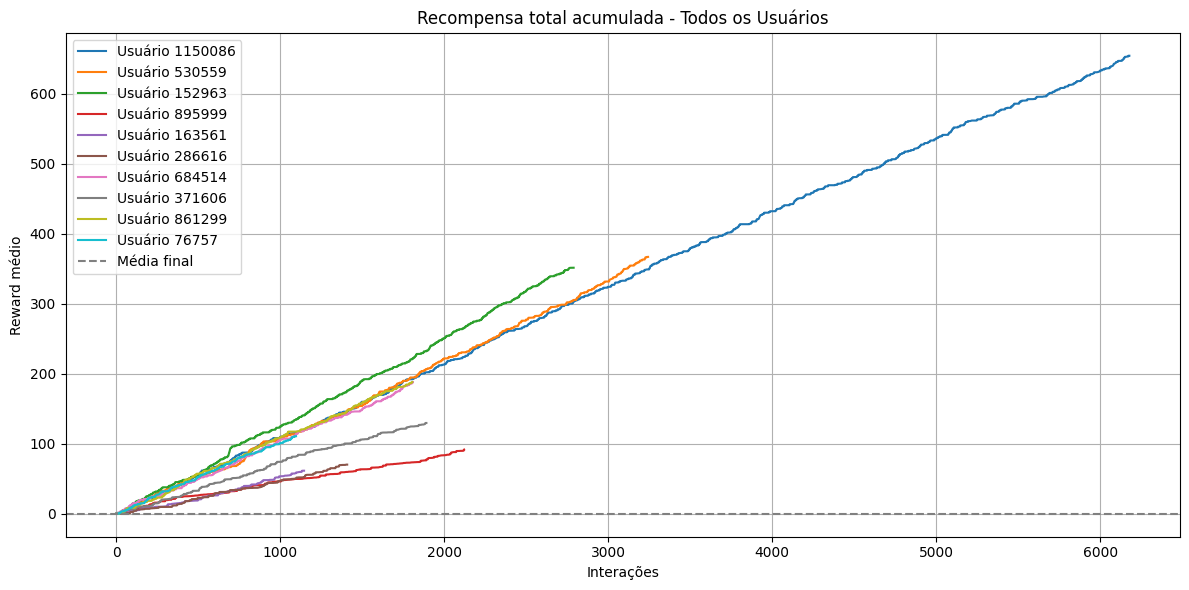

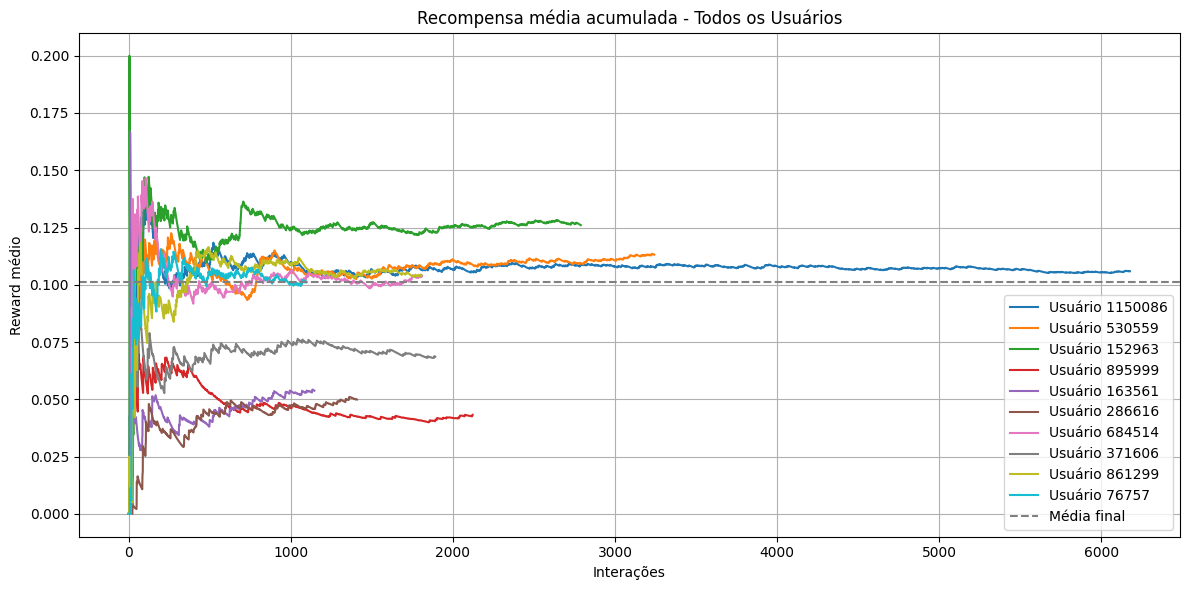

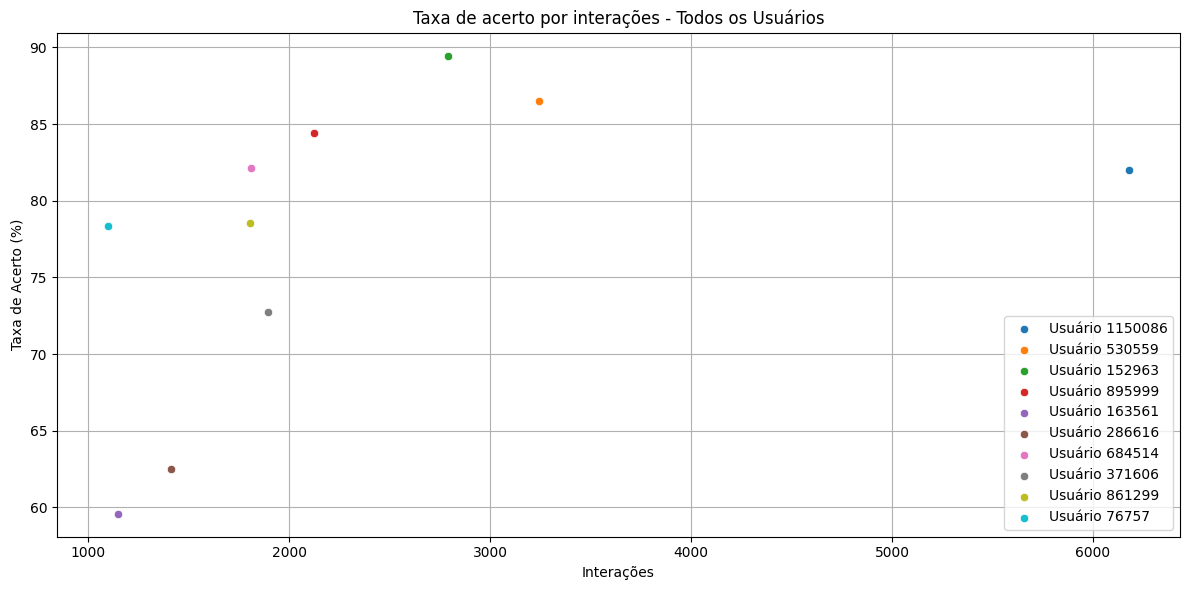

In [116]:
plot_cumulative_reward(results_no_norm)
plot_cumulative_average_reward(results_no_norm)
plot_accuracy_vs_interactions(results_no_norm)

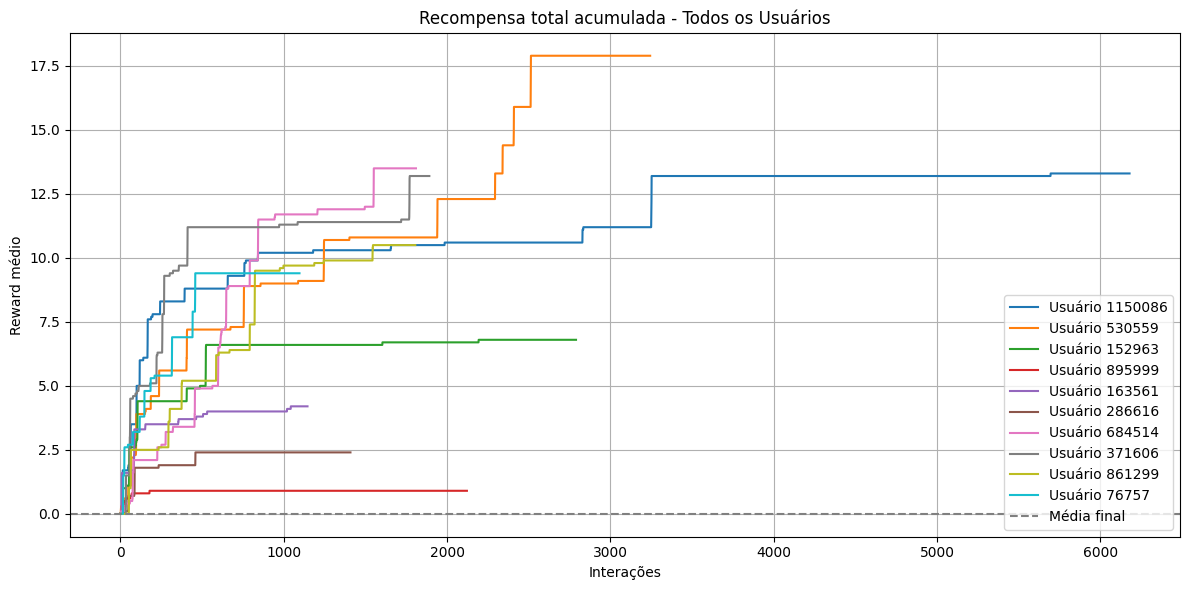

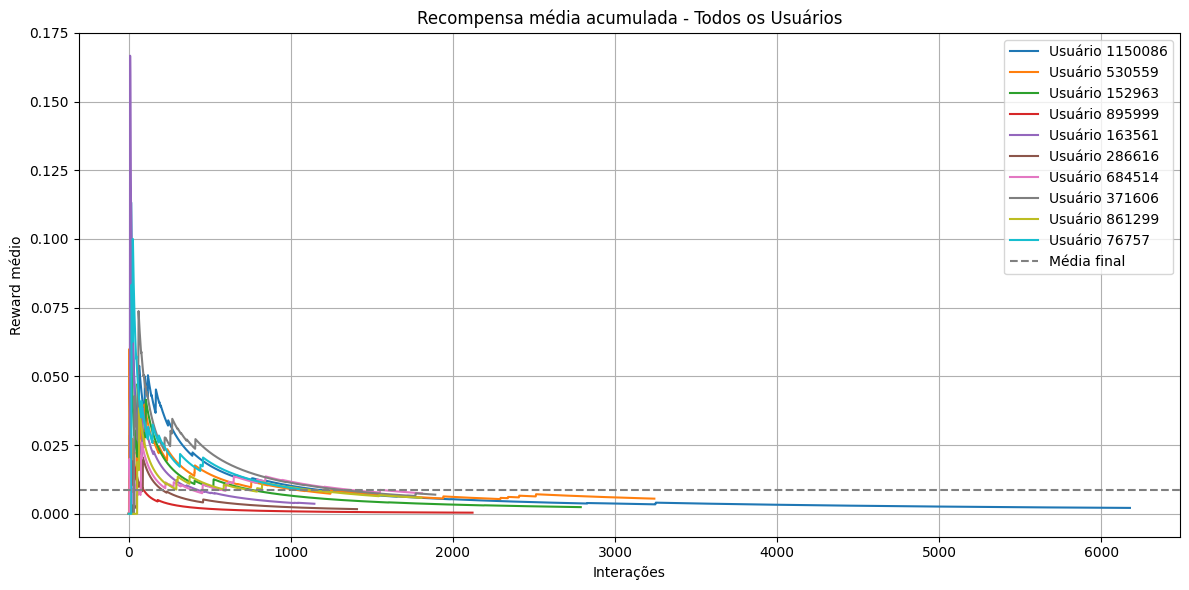

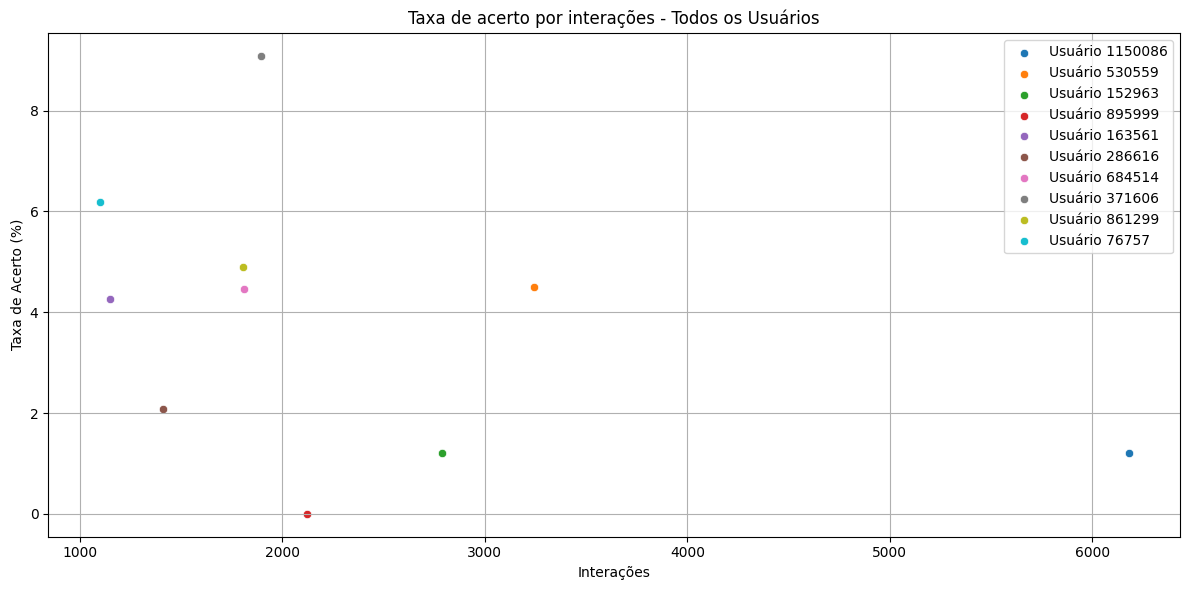

In [117]:
plot_cumulative_reward(results_with_norm)
plot_cumulative_average_reward(results_with_norm)
plot_accuracy_vs_interactions(results_with_norm)

In [120]:
results_no_norm_no_warmup = test_corrected_version(normalize_weights=False, warmup=0)
results_with_norm_no_warmup = test_corrected_version(normalize_weights=True, warmup=0)

🧪 TESTANDO VERSÃO CORRIGIDA
🎯 PROCESSAMENTO DO DATASET


Processando usuários:  10%|█         | 1/10 [29:31<4:25:45, 1771.72s/it]

✅ Usuário 1150086: reward=0.108, acertos=27.9%


Processando usuários:  20%|██        | 2/10 [45:57<2:54:34, 1309.32s/it]

✅ Usuário 530559: reward=0.113, acertos=28.0%


Processando usuários:  30%|███       | 3/10 [1:01:06<2:11:26, 1126.70s/it]

✅ Usuário 152963: reward=0.126, acertos=23.2%


Processando usuários:  40%|████      | 4/10 [1:11:30<1:32:48, 928.15s/it] 

✅ Usuário 895999: reward=0.043, acertos=20.2%


Processando usuários:  50%|█████     | 5/10 [1:15:20<56:22, 676.49s/it]  

✅ Usuário 163561: reward=0.053, acertos=21.3%


Processando usuários:  60%|██████    | 6/10 [1:20:09<36:19, 544.77s/it]

✅ Usuário 286616: reward=0.049, acertos=19.9%


Processando usuários:  70%|███████   | 7/10 [1:28:16<26:16, 525.65s/it]

✅ Usuário 684514: reward=0.099, acertos=25.0%


Processando usuários:  80%|████████  | 8/10 [1:37:20<17:43, 531.64s/it]

✅ Usuário 371606: reward=0.067, acertos=25.3%


Processando usuários:  90%|█████████ | 9/10 [1:46:37<08:59, 539.55s/it]

✅ Usuário 861299: reward=0.103, acertos=23.7%


Processando usuários: 100%|██████████| 10/10 [1:50:43<00:00, 664.37s/it]


✅ Usuário 76757: reward=0.105, acertos=22.8%

📊 RESULTADOS DO USUÁRIO 1150086:
   - Recompensa média: 0.108
   - Taxa de acerto: 27.86%
   - Recompensa total: 667.6
   - Total de recomendações: 6209

📊 RESULTADOS DO USUÁRIO 530559:
   - Recompensa média: 0.113
   - Taxa de acerto: 28.01%
   - Recompensa total: 368.4
   - Total de recomendações: 3274

📊 RESULTADOS DO USUÁRIO 152963:
   - Recompensa média: 0.126
   - Taxa de acerto: 23.23%
   - Recompensa total: 356.6
   - Total de recomendações: 2820

📊 RESULTADOS DO USUÁRIO 895999:
   - Recompensa média: 0.043
   - Taxa de acerto: 20.21%
   - Recompensa total: 92.6
   - Total de recomendações: 2152

📊 RESULTADOS DO USUÁRIO 163561:
   - Recompensa média: 0.053
   - Taxa de acerto: 21.34%
   - Recompensa total: 61.9
   - Total de recomendações: 1176

📊 RESULTADOS DO USUÁRIO 286616:
   - Recompensa média: 0.049
   - Taxa de acerto: 19.87%
   - Recompensa total: 70.0
   - Total de recomendações: 1439

📊 RESULTADOS DO USUÁRIO 684514:
   - R

Processando usuários:  10%|█         | 1/10 [29:24<4:24:44, 1764.90s/it]

✅ Usuário 1150086: reward=0.003, acertos=0.7%


Processando usuários:  20%|██        | 2/10 [56:32<3:44:32, 1684.03s/it]

✅ Usuário 530559: reward=0.006, acertos=1.6%


Processando usuários:  30%|███       | 3/10 [1:14:51<2:45:19, 1417.04s/it]

✅ Usuário 152963: reward=0.004, acertos=0.9%


Processando usuários:  40%|████      | 4/10 [1:24:56<1:49:38, 1096.36s/it]

✅ Usuário 895999: reward=0.001, acertos=0.5%


Processando usuários:  50%|█████     | 5/10 [1:28:46<1:05:19, 783.94s/it] 

✅ Usuário 163561: reward=0.003, acertos=1.4%


Processando usuários:  60%|██████    | 6/10 [1:33:26<40:50, 612.61s/it]  

✅ Usuário 286616: reward=0.002, acertos=1.0%


Processando usuários:  70%|███████   | 7/10 [1:41:33<28:34, 571.61s/it]

✅ Usuário 684514: reward=0.005, acertos=2.0%


Processando usuários:  80%|████████  | 8/10 [1:50:38<18:46, 563.24s/it]

✅ Usuário 371606: reward=0.008, acertos=1.9%


Processando usuários:  90%|█████████ | 9/10 [1:59:48<09:18, 558.94s/it]

✅ Usuário 861299: reward=0.005, acertos=1.1%


Processando usuários: 100%|██████████| 10/10 [2:03:47<00:00, 742.70s/it]

✅ Usuário 76757: reward=0.012, acertos=1.9%

📊 RESULTADOS DO USUÁRIO 1150086:
   - Recompensa média: 0.003
   - Taxa de acerto: 0.71%
   - Recompensa total: 16.7
   - Total de recomendações: 6209

📊 RESULTADOS DO USUÁRIO 530559:
   - Recompensa média: 0.006
   - Taxa de acerto: 1.56%
   - Recompensa total: 21.2
   - Total de recomendações: 3274

📊 RESULTADOS DO USUÁRIO 152963:
   - Recompensa média: 0.004
   - Taxa de acerto: 0.85%
   - Recompensa total: 11.5
   - Total de recomendações: 2820

📊 RESULTADOS DO USUÁRIO 895999:
   - Recompensa média: 0.001
   - Taxa de acerto: 0.51%
   - Recompensa total: 2.4
   - Total de recomendações: 2152

📊 RESULTADOS DO USUÁRIO 163561:
   - Recompensa média: 0.003
   - Taxa de acerto: 1.45%
   - Recompensa total: 3.4
   - Total de recomendações: 1176

📊 RESULTADOS DO USUÁRIO 286616:
   - Recompensa média: 0.002
   - Taxa de acerto: 1.04%
   - Recompensa total: 3.2
   - Total de recomendações: 1439

📊 RESULTADOS DO USUÁRIO 684514:
   - Recompensa méd

In [ ]:
# Fazer teste de warmup com 100 e 200
# Fazer com warmup de 80% das interações e validar com os 20%
# Fazer tabela comparativa de com e sem warmup
# Enviar tabela de pesos para o professor e explicação de como o vetor de pesos e contexto está sendo processado

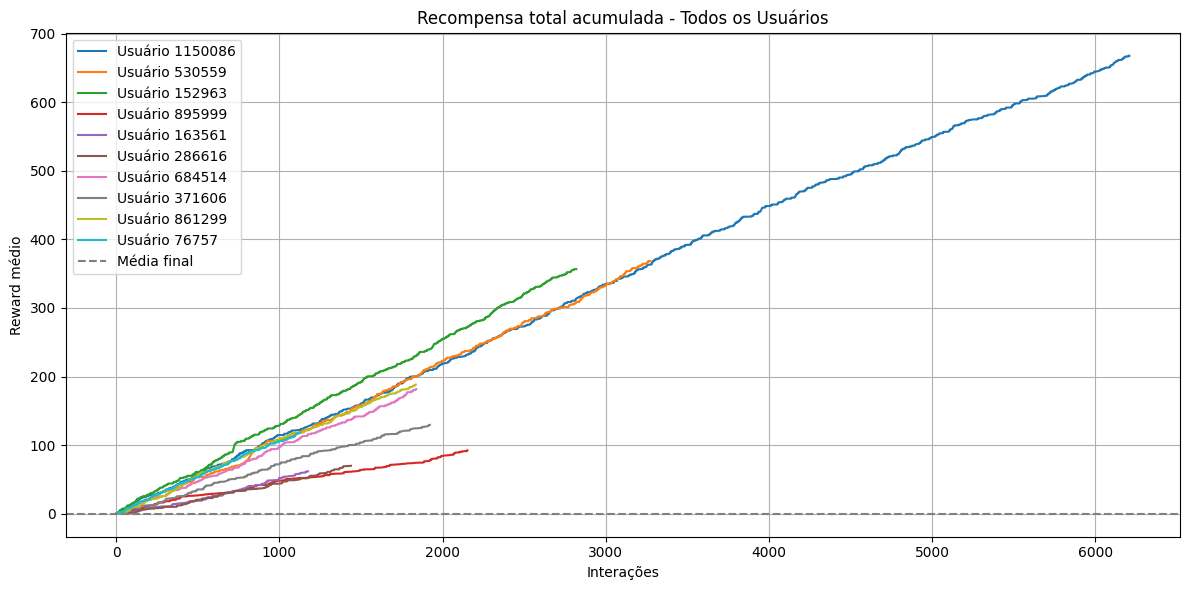

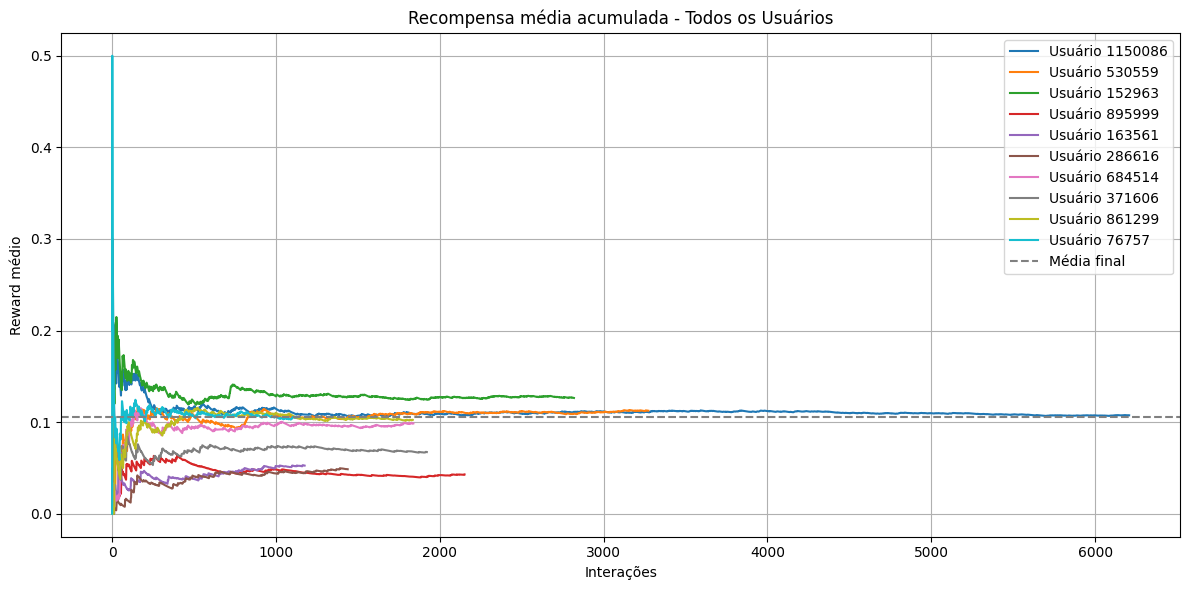

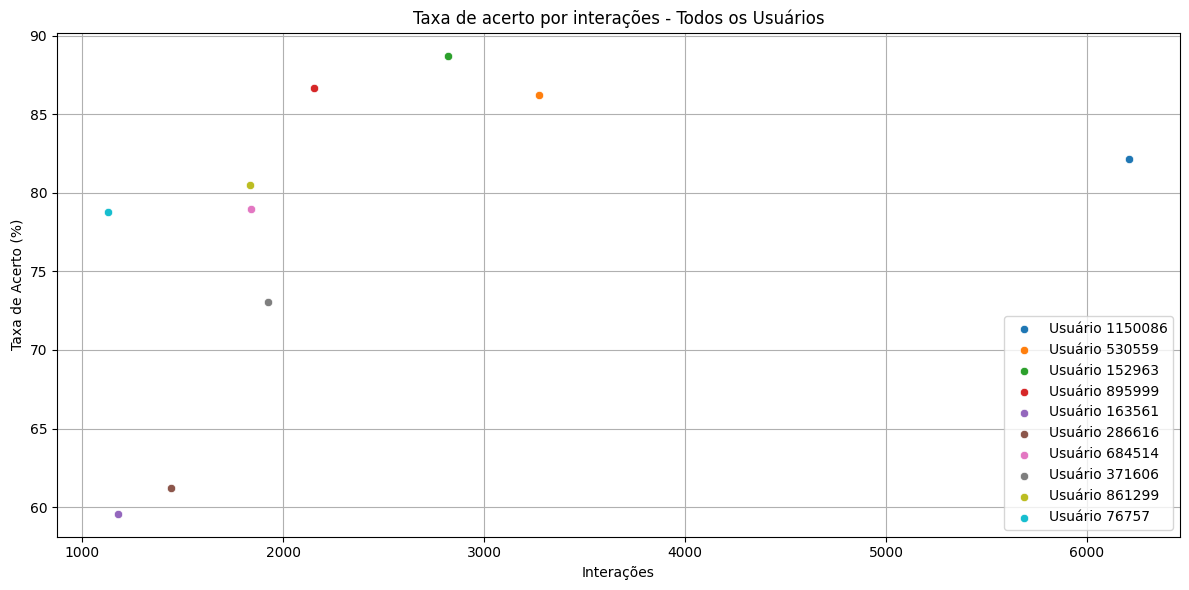

In [121]:
plot_cumulative_reward(results_no_norm_no_warmup)
plot_cumulative_average_reward(results_no_norm_no_warmup)
plot_accuracy_vs_interactions(results_no_norm_no_warmup)

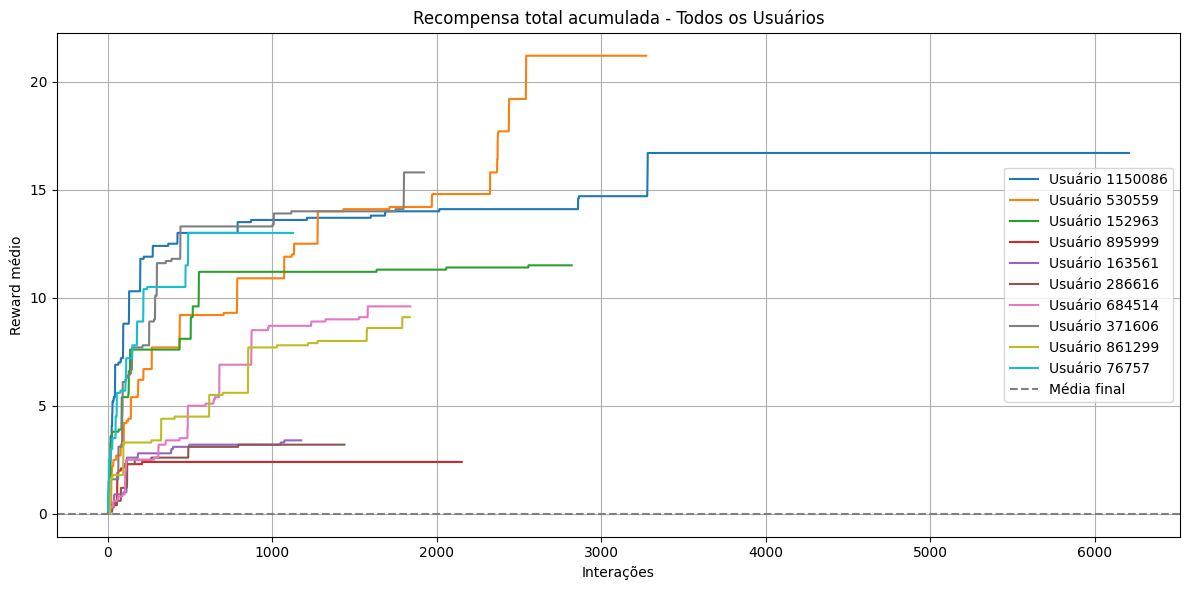

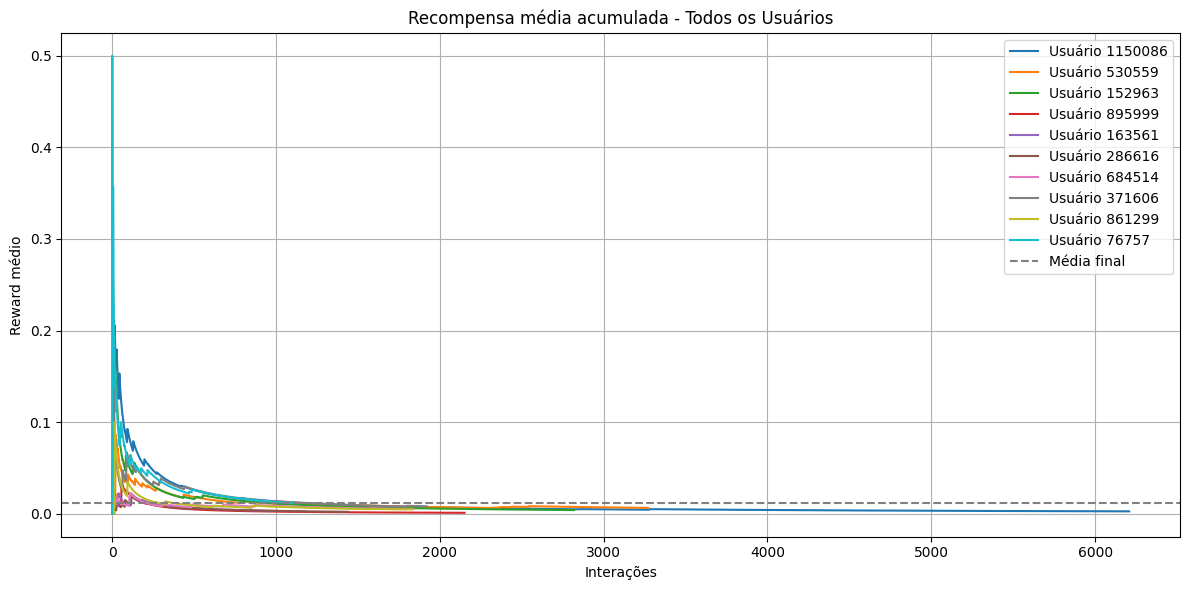

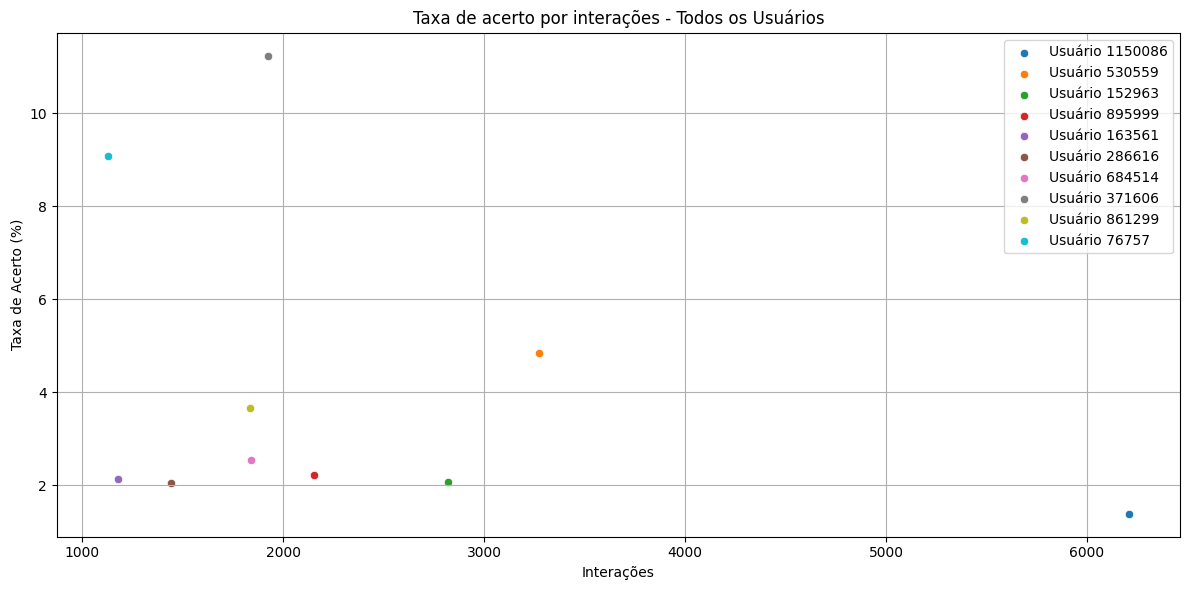

In [122]:
plot_cumulative_reward(results_with_norm_no_warmup)
plot_cumulative_average_reward(results_with_norm_no_warmup)
plot_accuracy_vs_interactions(results_with_norm_no_warmup)